In [1]:
import sys
sys.path.append('../utils')
from nd_tools import lee_filter

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans
from skimage.restoration import denoise_tv_bregman

The goals of this notebook are:

    
1. Introduce two despeckling techiniques for backscatter images, namely the [Lee Filter](https://earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf) and [Total Variation Denoising](https://www.ipol.im/pub/art/2012/g-tvd/).

2. To inspect how such despeckling improves the classification we began in earlier notebooks.

# Inspecting the Data

In [2]:
data_dir = Path('../data')
backscatter_tifs = sorted(list(data_dir.glob('./*backscatter*.tif')))
backscatter_tifs

[PosixPath('../data/alos_backscatter_hh.tif'),
 PosixPath('../data/alos_backscatter_hv.tif')]

In [3]:
with rasterio.open(backscatter_tifs[0]) as ds:
    hh = ds.read(1)
    profile = ds.profile

with rasterio.open(backscatter_tifs[1]) as ds:
    hv = ds.read(1)

# The Lee Filter

The Lee Filter we are using is from [Stackoverflow](https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python). We compare the variance throughout the image to the variance within a $n\times n$ window. We move the image's pixelwise value closer to the mean within the window proportionally to how close the window's variance matches the image's variance. We have included the code in our utils.

We can compare the original image with the filtered image.

In [4]:
hv_lee = lee_filter(hv, 5)

Text(0.5, 1.0, 'Lee HV')

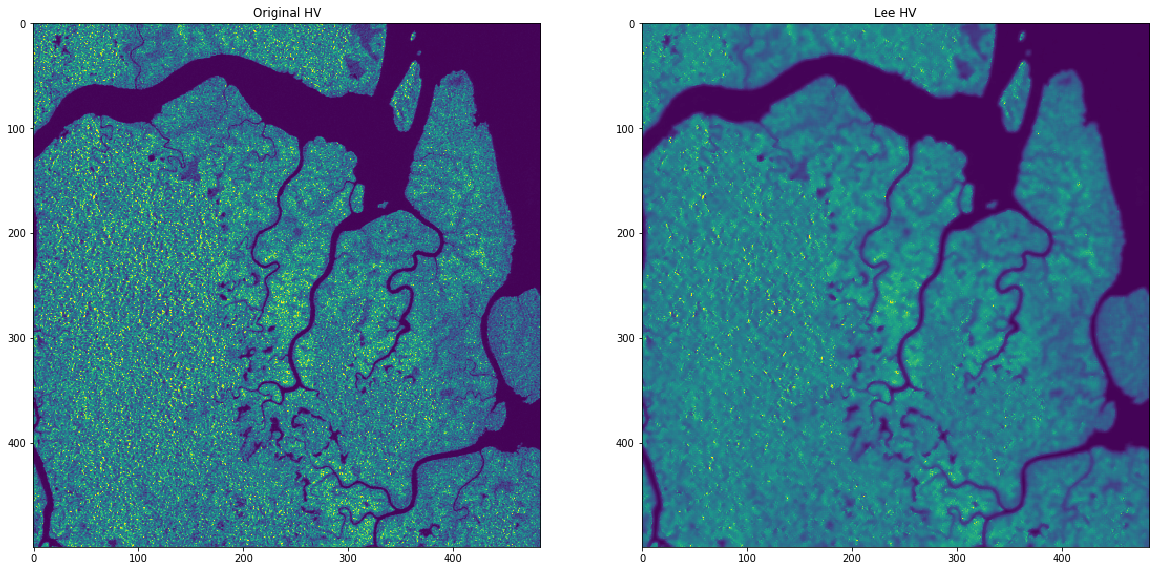

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(hv, vmin=0, vmax=.15)
ax[0].set_title('Original HV')

ax[1].imshow(hv_lee, vmin=0, vmax=.15)
ax[1].set_title('Lee HV')

Text(0.5, 1.0, 'Lee HV (Size=5)')

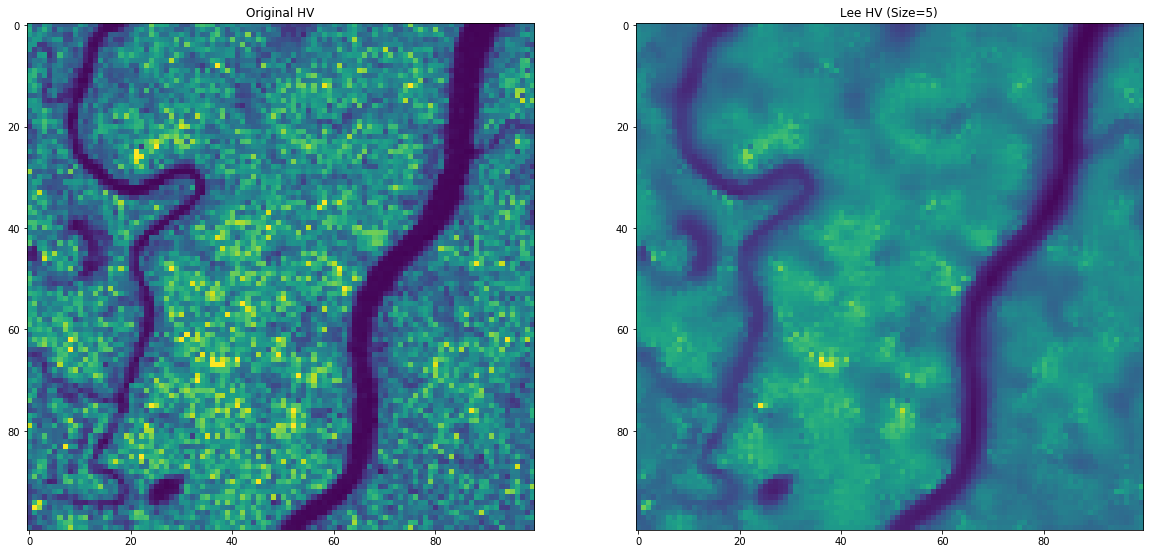

In [6]:
s_index = np.s_[200:300, 200: 300]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(hv[s_index], vmin=0, vmax=.15)
ax[0].set_title('Original HV')

ax[1].imshow(hv_lee[s_index], vmin=0, vmax=.15)
ax[1].set_title('Lee HV (Size=5)')

## Window sizes and Lee Filters

Let's look at how the size of the window affects the image. Can you explain why larger window sizes apprears to increase the smoothing?

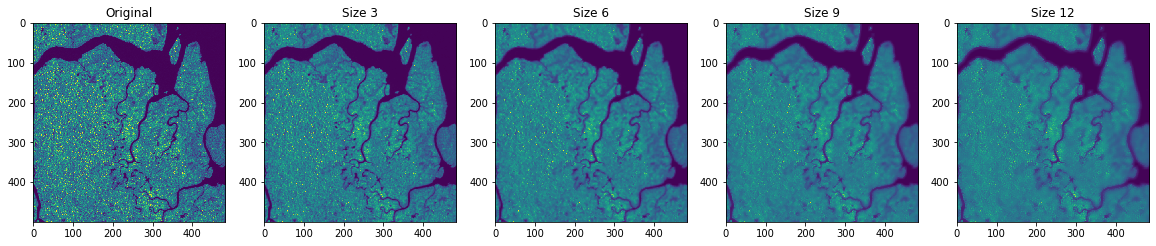

In [7]:
sizes = [0] + list(range(3, 13, 3))
N = len(sizes)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, size) in zip(ax.ravel(), sizes):
    if size == 0:
        ax.imshow(hv, vmin=0, vmax=.15)
        ax.set_title('Original')
    else:
        hv_lee = lee_filter(hv, size) 
        ax.imshow(hv_lee, vmin=0, vmax=.15)
        ax.set_title(f'Size {size}')

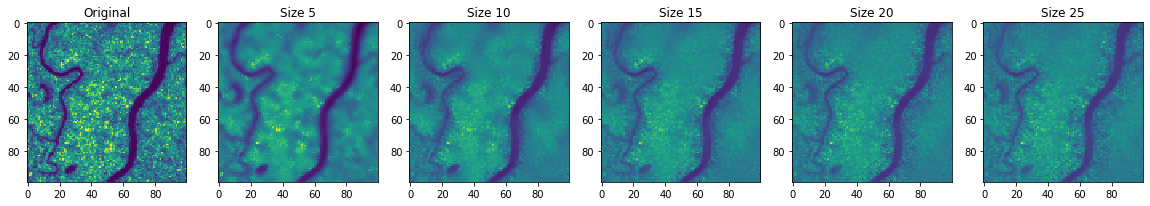

In [8]:
sizes = [0] + list(range(5, 26, 5))
N = len(sizes)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, size) in zip(ax.ravel(), sizes):
    if size == 0:
        ax.imshow(hv[s_index], vmin=0, vmax=.15)
        ax.set_title('Original')
    else:
        hv_lee = lee_filter(hv, size) 
        ax.imshow(hv_lee[s_index], vmin=0, vmax=.15)
        ax.set_title(f'Size {size}')

# Total Variation Denoising

Total variation denoising refers to the regularizeration term $|\nabla f|_1$ where we view the image as a function $f$ from the image pixel domain $\Omega \to \mathbb R$. This regularizer was first introduced [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.117.1675&rep=rep1&type=pdf) and a fast method for solving this optimization problem was introduced in this seminal [paper](ftp://ftp.math.ucla.edu/pub/camreport/cam08-29.pdf). Here is a nice [tutorial](https://www.ipol.im/pub/art/2012/g-tvd/). We use the implementation of this tool from skimage and [here](https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html) is an example.

We will apply it to SAR using the framework of ["MuLOG"](https://www.charles-deledalle.fr/pages/mulog.php) without debiasing since we are interested in classification and debiasing introduces a constant linear multiple to this image which is very close to unity. 

Simply put: we transform the image to decibels, denoise it with TV, and and then transform it back to linear units.

In [9]:
def fwd(img):
    return 10 * np.log10(img)

def bwd(img):
    return 10**(img / 10)

def tv_denoise(img, weight):
    img_db = fwd(img)
    img_db_tv = denoise_tv_bregman(img_db, weight)
    img_tv = bwd(img_db_tv)
    return img_tv

In [10]:
hv_tv = tv_denoise(hv, 1)

Text(0.5, 1.0, 'TV HV')

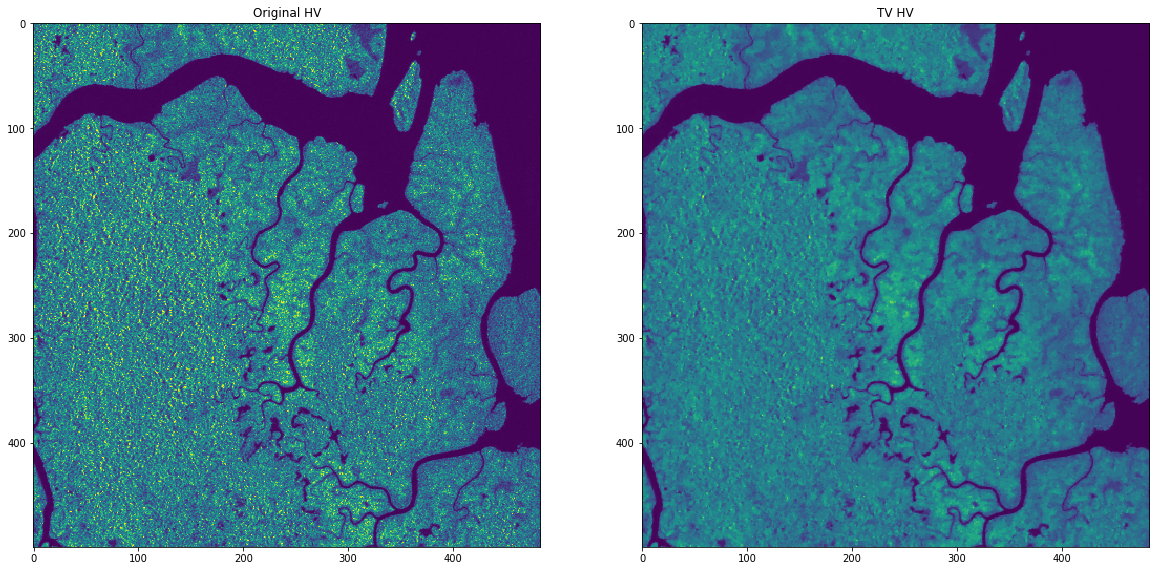

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(hv, vmin=0, vmax=.15)
ax[0].set_title('Original HV')

ax[1].imshow(hv_tv, vmin=0, vmax=.15)
ax[1].set_title('TV HV')

Text(0.5, 1.0, 'TV HV')

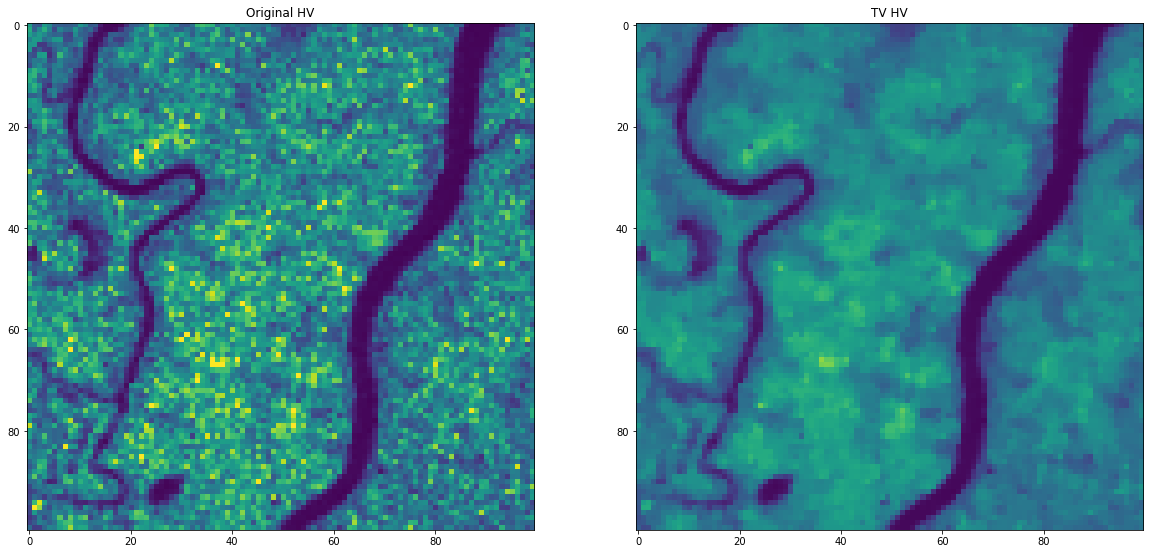

In [12]:
s_index = np.s_[200:300, 200: 300]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(hv[s_index], vmin=0, vmax=.15)
ax[0].set_title('Original HV')

ax[1].imshow(hv_tv[s_index], vmin=0, vmax=.15)
ax[1].set_title('TV HV')

# Excercise 1

Inspect the Weights for HV and HH.

In [13]:
## Answer

In [14]:
## Answer

In [15]:
## Answer

# Writing our Denoisied Images to TIF

We'll select a weight of .5 and write the rasters to tif. We can then inspect these denoised images in QGIS and compare them to the original images.

In [16]:
out_dir = Path('out')
out_dir.mkdir(exist_ok=True)

with rasterio.open(backscatter_tifs[0]) as ds:
    reference_profile = ds.profile

In [17]:
def open_one(path):
    with rasterio.open(path) as ds:
        img = ds.read(1)
    return img

def tv_partial(band):
    return tv_denoise(band, .5)

def write_one(band, name):
    dest_path = out_dir/name
    with rasterio.open(dest_path, 'w', **reference_profile) as ds:
        ds.write(band, 1)
    return dest_path
        
def tv_writer(path):
    band = open_one(path)
    band_tv = tv_partial(band)
    print(band_tv.shape)
    dest_path = write_one(band_tv, path.name.replace('.tif', '_tv.tif'))
    return dest_path

In [18]:
list(map(tv_writer, backscatter_tifs))

(500, 484)
(500, 484)


[PosixPath('out/alos_backscatter_hh_tv.tif'),
 PosixPath('out/alos_backscatter_hv_tv.tif')]

# Excercise 2

Use k-means with three classes on the denoised images What do you observe?

In [19]:
## Answer

In [20]:
## Answer

In [21]:
## Answer

In [22]:
## Answer

In [23]:
## Answer

# Acknowledgements

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.